# timeseries cnn

時系列データを1次元畳み込みで学習する

## 参考

時系列予測を一次元畳み込みを使って解く with Keras
https://qiita.com/niisan-tokyo/items/a94dbd3134219f19cab1

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from keras.layers.convolutional import Conv1D, UpSampling1D
from keras.layers.pooling import MaxPooling1D

/home/tatsuki/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 時系列データ生成

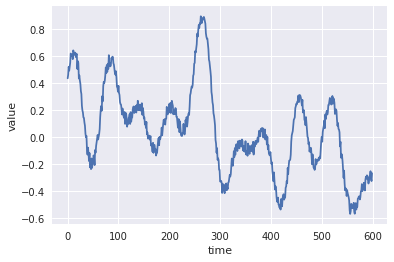

In [7]:
timeline = np.arange(10000)
epochs = 30

def sinnp(n, line):
    return np.sin(line*n/100)
def cosnp(n, line):
    return np.cos(line*n/100)

raw_data = (sinnp(1, timeline) + sinnp(3, timeline) + sinnp(10, timeline) + cosnp(5, timeline) + cosnp(7, timeline)) / 5
raw_data = raw_data + (np.random.rand(len(timeline)) * 0.1)# ノイズ項
plt.plot(timeline[:600], raw_data[:600])
plt.xlabel("time")
plt.ylabel("value")
plt.show()

## 前処理

連続した64個の時系列データを元に、次の16個の時系列データを生成(予測)する
input_dataがtrain_data, output_dataがlabelとなる

In [8]:
input_data = []
output_data = []
for n in range(10000-80):
    input_data.append(raw_data[n:n+64])
    output_data.append(raw_data[n+64:n+80])

input_data = np.array(input_data)
output_data = np.array(output_data)
print(input_data.shape)
print(output_data.shape)

(9920, 64)
(9920, 16)


一次元畳み込みそうにおける入力の形状(shape)は(<シーケンス長>, <パラメータ数>)となる

入力データの整形

In [9]:
train_X = np.reshape(input_data, (-1, 64, 1))
train_Y = np.reshape(output_data, (-1, 16, 1))
print(train_X.shape)
print(train_Y.shape)

(9920, 64, 1)
(9920, 16, 1)


## モデル作成と学習

In [10]:
model = Sequential()
model.add(Conv1D(64, 8, padding='same', input_shape=(64, 1), activation='relu'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(64, 8, padding='same', activation='relu'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(32, 8, padding='same', activation='relu'))
model.add(Conv1D(1, 8, padding='same', activation='tanh'))

model.compile(loss='mse', optimizer='adam')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 64, 64)            576       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 32, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 32, 64)            32832     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 16, 32)            16416     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 16, 1)             257       
Total params: 50,081
Trainable params: 50,081
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(train_X, train_Y, validation_split=0.1, epochs=epochs)

Train on 8928 samples, validate on 992 samples
Epoch 1/30
8928/8928 [==============================] - 4s 404us/step - loss: 0.0320 - val_loss: 0.0091
Epoch 2/30
8928/8928 [==============================] - 3s 366us/step - loss: 0.0064 - val_loss: 0.0049
Epoch 3/30
8928/8928 [==============================] - 4s 395us/step - loss: 0.0048 - val_loss: 0.0040
Epoch 4/30
8928/8928 [==============================] - 3s 377us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 5/30
8928/8928 [==============================] - 3s 377us/step - loss: 0.0035 - val_loss: 0.0038
Epoch 6/30
8928/8928 [==============================] - 3s 390us/step - loss: 0.0034 - val_loss: 0.0038
Epoch 7/30
8928/8928 [==============================] - 3s 385us/step - loss: 0.0031 - val_loss: 0.0028
Epoch 8/30
8928/8928 [==============================] - 3s 371us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 9/30
8928/8928 [==============================] - 3s 369us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/30
8928/

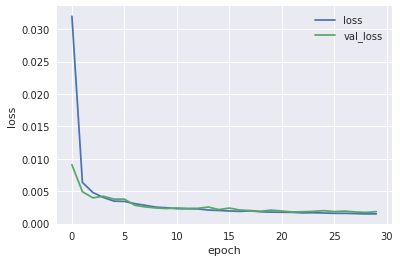

In [13]:
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend() 
plt.show()

## 学習器を用いて予測

(1, 384, 1)
(384,)


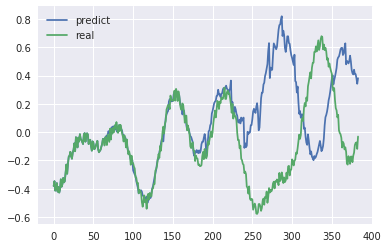

In [14]:
start = 9100
sheed = np.reshape(raw_data[start:start+64], (1, 64, 1))
prediction = sheed

for i in range(20):
    res = model.predict(sheed)
    sheed = np.concatenate((sheed[:, 16:, :], res), axis=1)
    prediction = np.concatenate((prediction, res), axis=1)

print(prediction.shape)
predictor = np.reshape(prediction, (-1))
print(predictor.shape)
plt.plot(range(len(predictor)), predictor, label='predict')
plt.plot(range(len(predictor)), raw_data[start:start + len(predictor)], label='real')
plt.legend() 
plt.show()